<a href="https://colab.research.google.com/github/SebastijanKokai/Face-recognition-algorithms/blob/main/SebastijanKokai_FaceRecognitionModelTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UVOD

#### Kao base model sam koristio MobileNetV2 sa ImageNet weights, freeze-ovao sam njegove slojeve i nakon toga istrenirao još slojeve koje sam dodao. Za trening i validaciju sam koristio dataset koji sam dobio sa 80/20 split-om za trening i validaciju. Validation accuracy mi je 84% nakon 20 epoha. Takođe, treba uzeti u obzir da je dataset zaista mali. Koristio sam Adam optimizer i categorical_crossentropy za loss funkciju. Poslednji (Dense) sloj ima softmax aktivacionu funkciju. Tako da rezultat izvlačim pomoću np.argmax funkcije, ona određuje index osobe koju prepoznaje na slici. Posle toga preostaje samo da ispišem ime osobe koju je prepoznao.

## **Problemi** na koje sam naleteo:
- Kako sa google drive link-a skinuti dataset direktno u Colab
- Kako sačuvati i učitati model
- Preveliki batch size, s toga i nizak accuracy
- cv2.imshow je u Colab-u posebna funkcija koja se mora importovati i poziva se sa cv2_imshow
- Kako izvući predikciju nakon istreniranog modela i šta uopšte predstavljaju brojevi koji se dobiju sa softmax funkcijom

In [ ]:
# Download and unzip dataset
!gdown --id 1sk0Uuycy_l9_SRmcWMIijhTwOAP-usnw
!unzip '#2.zip'

In [ ]:
from google.colab import files
files.upload()

{}

In [2]:
import tensorflow as tf
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
base_dir = './cropped_images/'
print(tf.__version__)
IMAGE_SIZE = 224
BATCH_SIZE = 16

2.6.0


In [4]:
# Data generator which rescales the images
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    validation_split=0.2
)

In [5]:
train_generator = data_generator.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training'
)

Found 221 images belonging to 5 classes.


In [6]:
val_generator = data_generator.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation'
)

Found 53 images belonging to 5 classes.


In [7]:
# Triggering a training generator for all the batches
for image_batch, label_batch in train_generator:
    break

# Print all classification labels
print(train_generator.class_indices)

{'chris_evans': 0, 'chris_hemsworth': 1, 'mark_ruffalo': 2, 'robert_downey_jr': 3, 'scarlett_johansson': 4}


In [8]:
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
# Writing it out to the file which will be named labels.txt
with open('labels.txt', 'w') as f:
    f.write(labels)

In [9]:
# Create the base model from pre-trained CNN
# MobileNet V2
# Use last layer for feature extraction

# Resolution of images (Width, Height, Array of size 3 to accomodate RGB Colors)
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [10]:
base_model.trainable = False

In [11]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),  # 32 nodes, 3 kernel size
    tf.keras.layers.Dropout(0.2),  # drop nodes that are not contributing to the final output, 20%
    tf.keras.layers.GlobalAveragePooling2D(),  # 2x2 matrix pooling for size reduction
    tf.keras.layers.Dense(5, activation='softmax')  # takes input of all previous layers and applies softmax before
    # sending it forward
])


In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(),  # change weights, learning rates to reduce losses
              loss='categorical_crossentropy',  # weights are changed depending on the LOSS
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


In [13]:
# See model summary in tabular structure
model.summary()

print('Number of trainable variables = {}'.format(len(model.trainable_variables)))



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 2,626,821
Trainable params: 368,837
Non-trainable params: 2,257,984
_________________________________________________________________
Number of trainable variables = 4


In [14]:
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [15]:
model_earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [16]:
# Define epochs
epochs = 10
# Fitting / training the model
history = model.fit(train_generator,
                    epochs=epochs,
                    callbacks=[model_checkpoint_callback, model_earlystopping_callback],
                    validation_data=val_generator)

Epoch 1/10
14/14 [==============================] - 12s 599ms/step - loss: 2.9500 - accuracy: 0.2851 - precision: 0.3000 - recall: 0.1629 - val_loss: 1.4902 - val_accuracy: 0.2264 - val_precision: 1.0000 - val_recall: 0.0566
Epoch 2/10
14/14 [==============================] - 8s 540ms/step - loss: 1.3956 - accuracy: 0.3846 - precision: 1.0000 - recall: 0.1267 - val_loss: 1.4729 - val_accuracy: 0.2453 - val_precision: 0.8182 - val_recall: 0.1698
Epoch 3/10
14/14 [==============================] - 8s 541ms/step - loss: 1.2610 - accuracy: 0.4389 - precision: 0.8627 - recall: 0.1991 - val_loss: 1.5056 - val_accuracy: 0.3208 - val_precision: 0.6429 - val_recall: 0.1698
Epoch 4/10
14/14 [==============================] - 8s 546ms/step - loss: 1.1227 - accuracy: 0.4706 - precision: 0.8250 - recall: 0.2986 - val_loss: 1.4374 - val_accuracy: 0.4528 - val_precision: 0.7333 - val_recall: 0.2075
Epoch 5/10
14/14 [==============================] - 8s 545ms/step - loss: 0.9830 - accuracy: 0.5475 - p

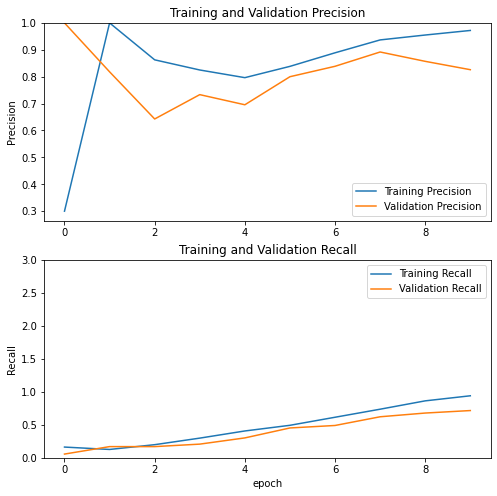

In [19]:
# Recall and precision
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.legend(loc='lower right')
plt.ylabel('Precision')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Precision')
plt.subplot(2, 1, 2)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='upper right')
plt.ylabel('Recall')
plt.ylim([0, 3])
plt.title('Training and Validation Recall')
plt.xlabel('epoch')
plt.show()


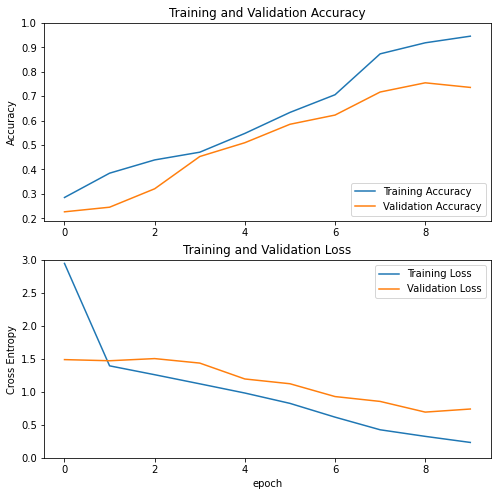

In [20]:
# Visualizing the Learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 3])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [21]:
# Load the weights of the best model
model.load_weights(checkpoint_filepath)

In [ ]:
# Saving the Trained Model.
saved_model_dir = 'save/face_rec_model.h5'
model.save(saved_model_dir)
print("Model Saved to save/face_rec_model")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Model Saved to save/face_rec_model


In [ ]:
# Upload already trained model
from google.colab import files
files.upload()

Saving face_rec_model.h5 to face_rec_model.h5


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
from os import listdir
from os.path import isfile, join
from google.colab.patches import cv2_imshow # cv2_imshow

In [ ]:
# Load the model
model = tf.keras.models.load_model("./face_rec_model.h5")
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
facial_recog_dict = {}
key = 0
facial_recog_dict_file = open('labels.txt')
for line in facial_recog_dict_file:
    value = line.split()
    facial_recog_dict[str(key)] = value
    key += 1
print(facial_recog_dict)

{'0': ['chris_evans'], '1': ['chris_hemsworth'], '2': ['mark_ruffalo'], '3': ['robert_downey_jr'], '4': ['scarlett_johansson']}


In [ ]:
def getRandomImage(path):
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0, len(folders))
    path_class = folders[random_directory]

    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0, len(file_names))
    image_name = file_names[random_file_index]

    return cv2.imread(file_path + "/" + image_name)

In [ ]:
def draw_test(prediction, img):
    facial = facial_recog_dict[str(prediction)]
    img_show = cv2.resize(img, (int(300), int(300)))
    cv2.putText(img_show, str(facial), (0, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    cv2_imshow(img_show)

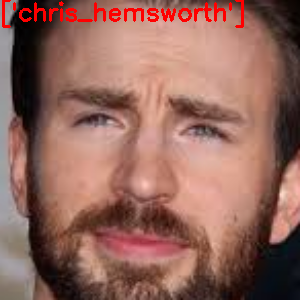

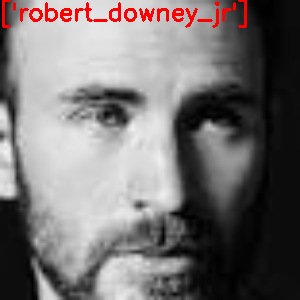

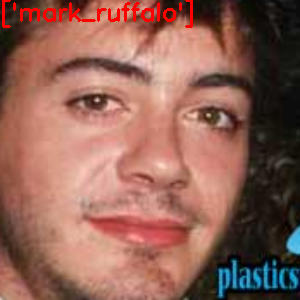

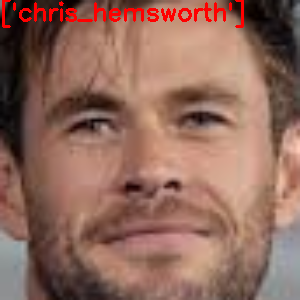

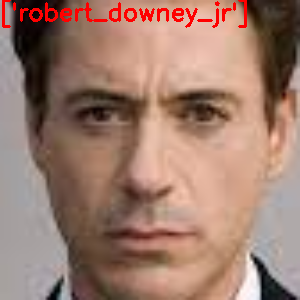

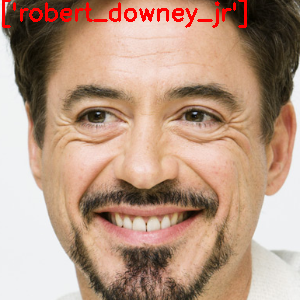

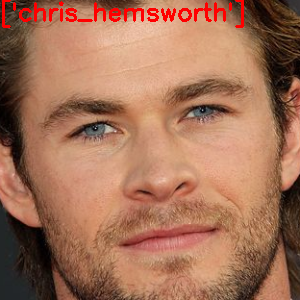

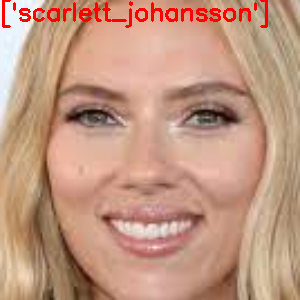

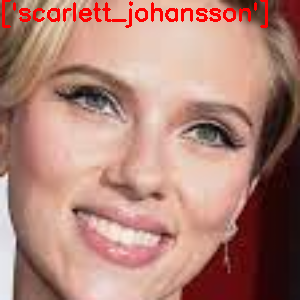

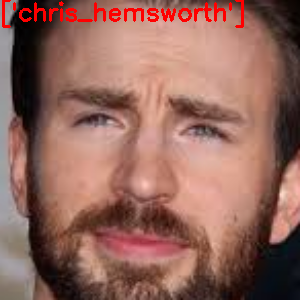

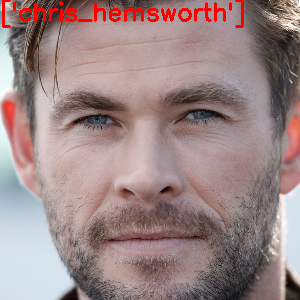

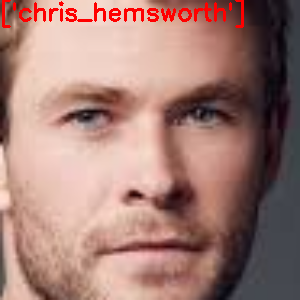

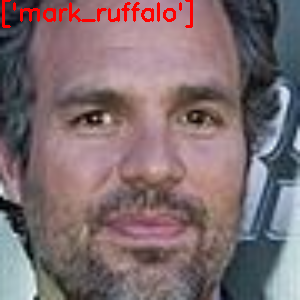

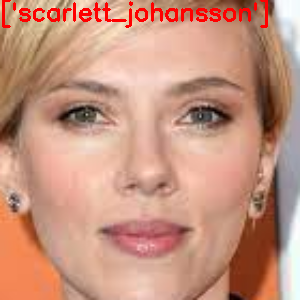

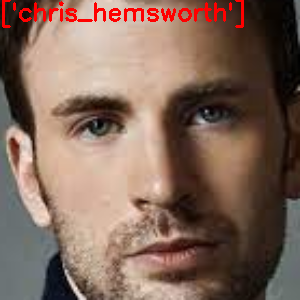

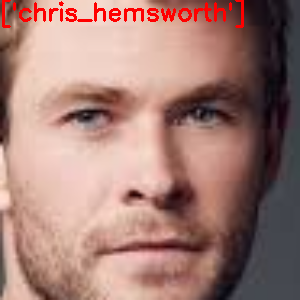

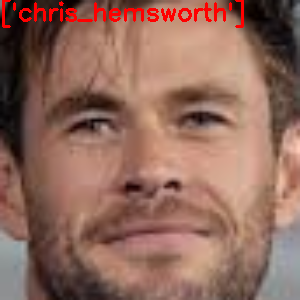

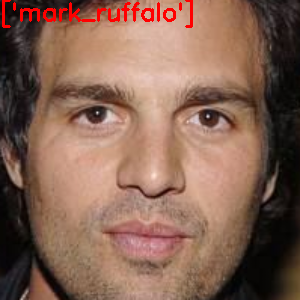

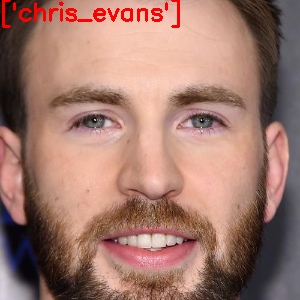

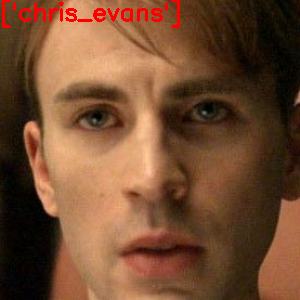

In [ ]:
for i in range(0, 20):
    input_im = getRandomImage('./cropped_images/')
    input_original = input_im.copy()

    input_im = cv2.resize(input_im, (224, 224))
    input_im = input_im / 255.
    input_im = input_im.reshape(1, 224, 224, 3)

    # Get prediction
    res = np.argmax(model.predict(input_im, 1, verbose=0))

    # Show image with predicted class
    draw_test(res, input_original)

# ZAKLJUČAK

#### Možemo da vidimo da je model tačan u većini slučajeva i verovatno bi sa još većim dataset-om bio tačniji. Postoji mogućnost da se model dodatno fine tune-uje i tada bi imao još veći validation accuracy. Svakako, zadatak jeste bio napraviti model za detekciju lica uspomoć dataset-a koji nam je dat i mislim da ovaj model zadovoljava kriterijum zadatka.

# LITERATURA (Izvori)

- https://machinelearningmastery.com/softmax-activation-function-with-python/
- https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e
- https://stackoverflow.com/questions/37891954/keras-how-do-i-predict-after-i-trained-a-model
- https://www.geeksforgeeks.org/python-opencv-cv2-copymakeborder-method/
- https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/
- https://medium.com/analytics-vidhya/face-recognition-using-transfer-learning-on-mobilenet-cf632e25353e